In [2]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import pandas as pd

In [96]:

nb_of_clusters = 5
dataset, _ = datasets.make_blobs(n_samples=500, centers=nb_of_clusters, n_features=2)  # n_features : nombre de dimensions


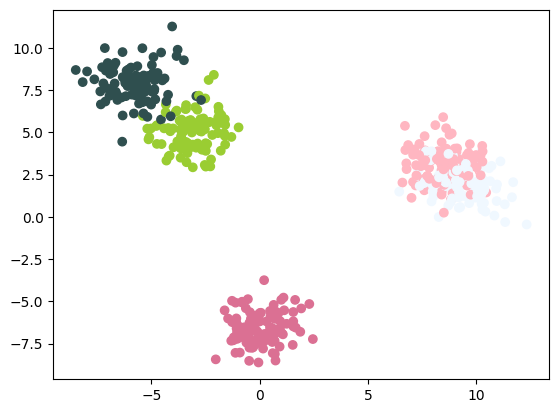

In [3]:
def visualize_clustersV1(dataset, centers=None, title=None):

    colors = list(mcolors.CSS4_COLORS.keys())
    plt.scatter(dataset[:, 0], dataset[:, 1], c=_, cmap=mcolors.ListedColormap(colors))

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red')
    plt.show()


visualize_clustersV1(dataset)

In [86]:
def visualize_clusters(dataset, centers=None, title=None): #V2 - 3D
    colors = list(mcolors.CSS4_COLORS.keys())
    if dataset.shape[1] == 2:
        plt.scatter(dataset[:, 0], dataset[:, 1], c=_, cmap=mcolors.ListedColormap(colors))
    elif dataset.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=_, cmap=mcolors.ListedColormap(colors))
    else:
        raise ValueError("Visualization not implemented for more than 3 dimensions")

    if centers is not None:
        if centers.shape[1] == 2:
            plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)  # Use 'x' marker with larger size
        elif centers.shape[1] == 3:
            ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=100)
        else:
            raise ValueError("Visualization not implemented for more than 3 dimensions")

    plt.show()

In [88]:

def sse_distance(a, b):
    return np.sum((a-b)**2)

def find_closest_center(centers, data):
    distances = []
    for center in centers:
        distances.append(sse_distance(center, data))
    return np.argmin(distances)

def compute_clusters(centers, data):
    clusters = []
    for point in data:
        clusters.append(find_closest_center(centers, point))
    return clusters

def sse_error(centers, data):
    clusters = compute_clusters(centers, data)
    error = 0
    for i in range(len(clusters)):
        error += sse_distance(data[i], centers[clusters[i]])
    return error


In [89]:
def initialize_centers(data, k):
    centers = []
    for i in range(k):
        centers.append(data[np.random.randint(0, len(data))])
    return centers

In [97]:
 # KMEANS ++
def initialize_centers2(data, k):
    centers = []
    # Sélectionner aléatoirement le premier centre parmi les points de données
    centers.append(data[np.random.randint(0, len(data))])

    for _ in range(1, k):
        distances = []
        for point in data:
            # Pour chaque point, calculer la distance au centre le plus proche déjà choisi
            min_distance = min(sse_distance(point, c) for c in centers)
            distances.append(min_distance)

        # Probabilité proportionnelle à la distance au centre le plus proche déjà choisi
        probabilities = np.array(distances) / sum(distances)
        
        # Choisir le nouveau centre avec une probabilité proportionnelle à la distance au centre déjà choisi
        new_center_index = np.random.choice(len(data), p=probabilities)
        centers.append(data[new_center_index])

    return np.array(centers)



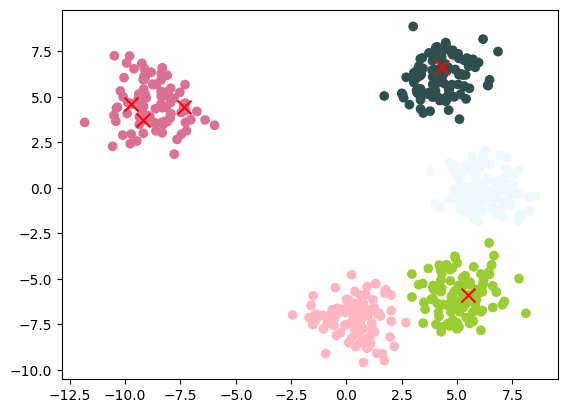

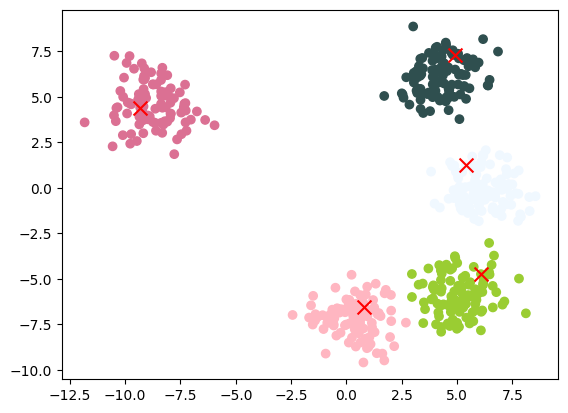

[array([4.31154082, 6.42818499]), array([6.88139598, 0.15168112]), array([ 0.75790076, -6.30863151]), array([3.04597227, 5.78857209]), array([4.89983249, 7.31059166])]


In [99]:

## Différentes initialisations entre l'intitialisation aléatoire et l'initialisation KMEANS ++

centers = initialize_centers(dataset, nb_of_clusters)
visualize_clusters(dataset, np.array(initialize_centers(dataset, nb_of_clusters))) # Initialisation aléatoire
visualize_clusters  (dataset, np.array(initialize_centers2(dataset, nb_of_clusters))) # KMEANS ++

In [9]:
def check_cluster_membership(center, centers, clusters):
    # Vérifie si le centre est dans le même cluster qu'un autre centre
    center_index = np.where(centers == center)[0][0]
    center_cluster = clusters[center_index]
    other_centers_indices = np.where(centers != center)[0]
    for idx in other_centers_indices:
        if clusters[idx] == center_cluster:
            return True  # Si un autre centre est dans le même cluster
    return False

Iteration 1


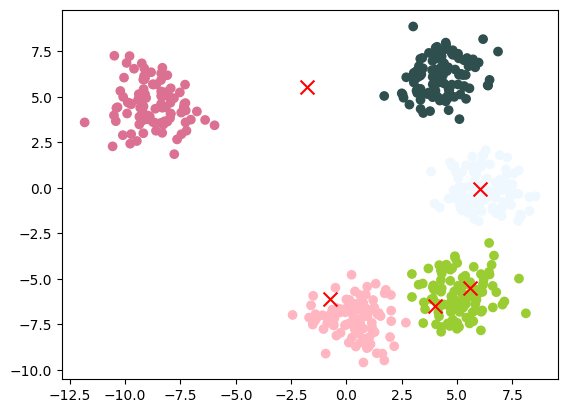

Iteration 2


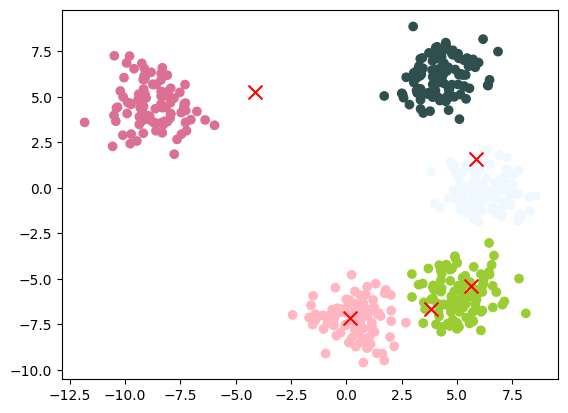

Iteration 3


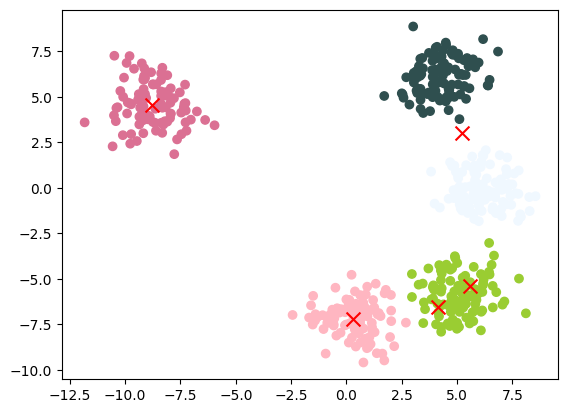

Iteration 4


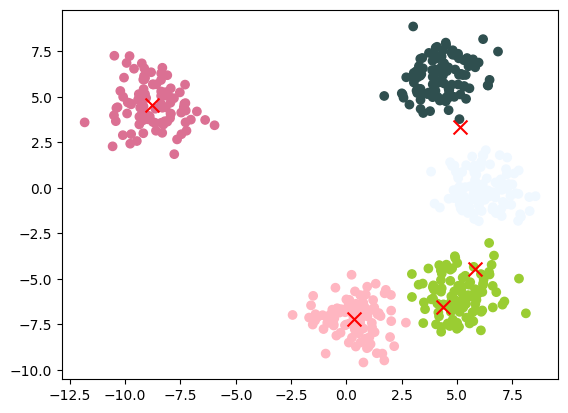

Iteration 5


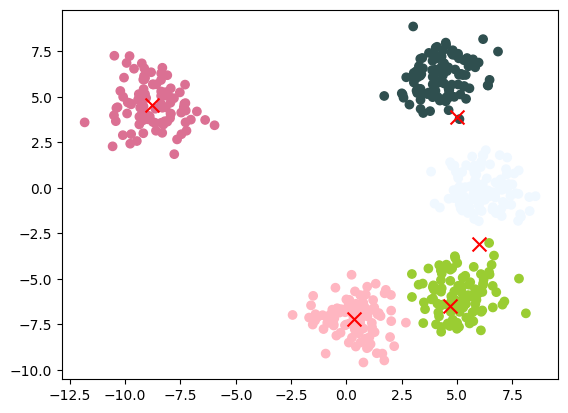

Iteration 6


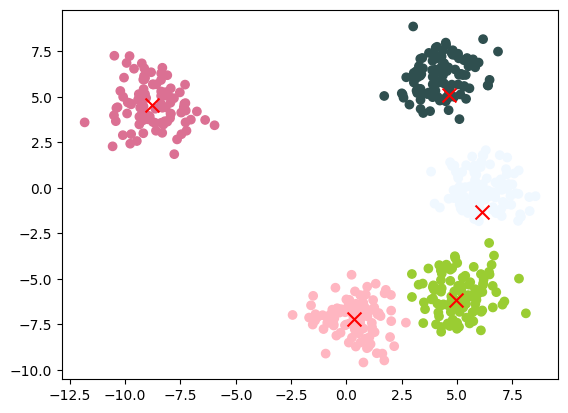

Iteration 7


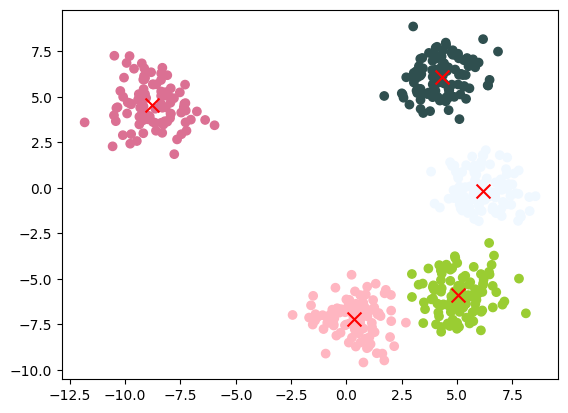

Iteration 8


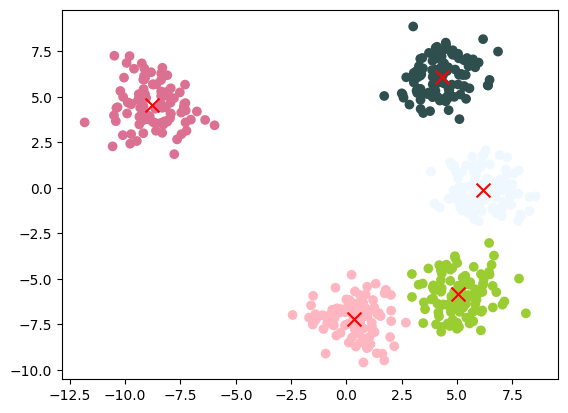

Iteration 9


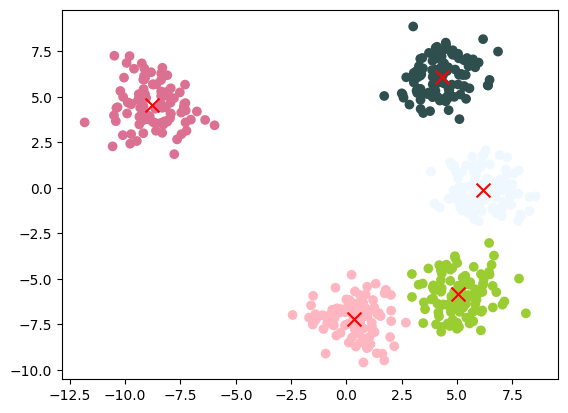

Iteration 10


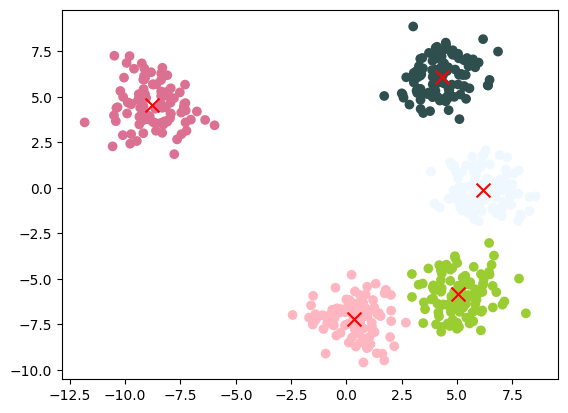

Iteration 11


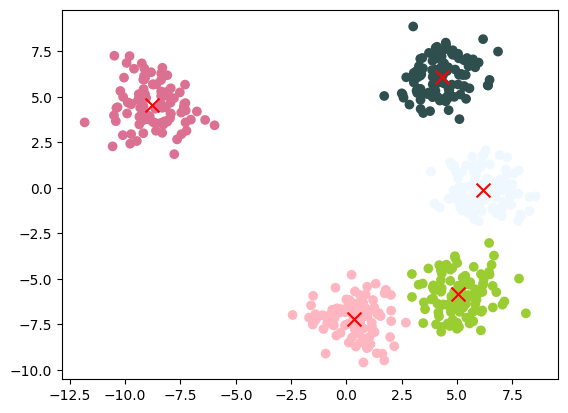

Iteration 12


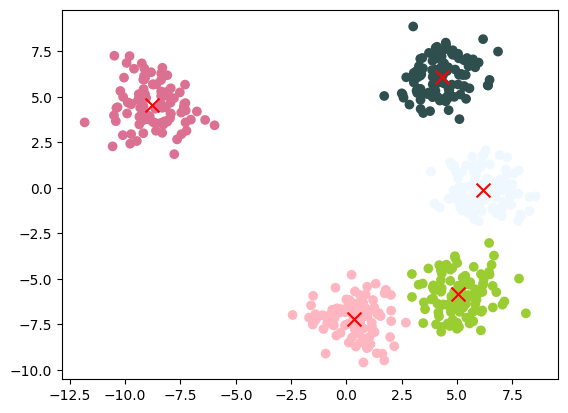

Iteration 13


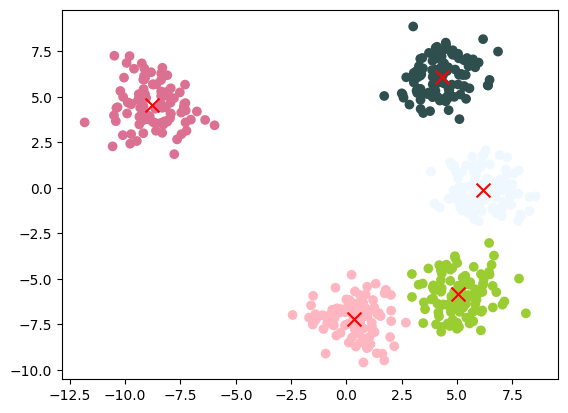

Iteration 14


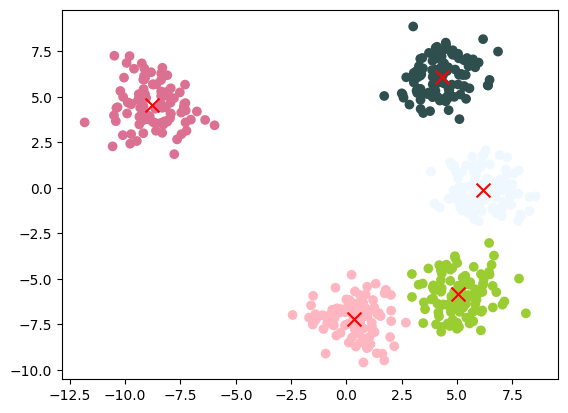

Iteration 15


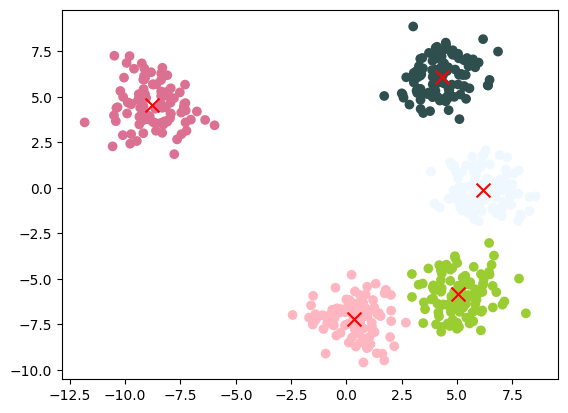

Iteration 16


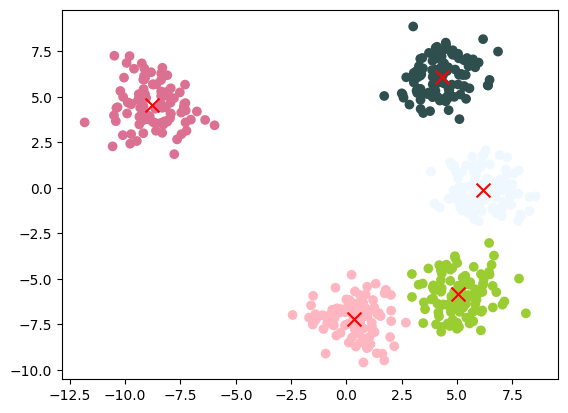

Iteration 17


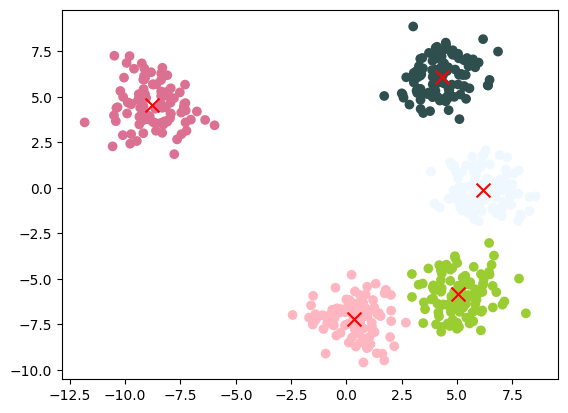

Iteration 18


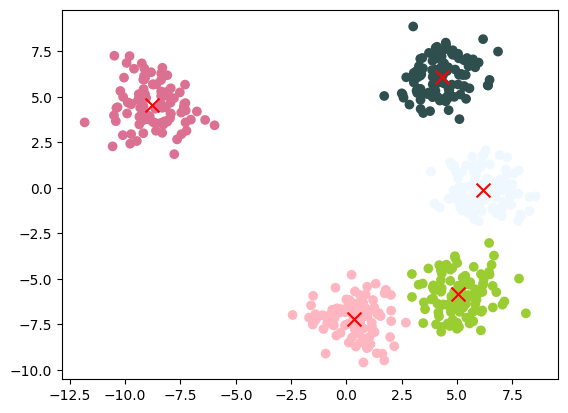

Iteration 19


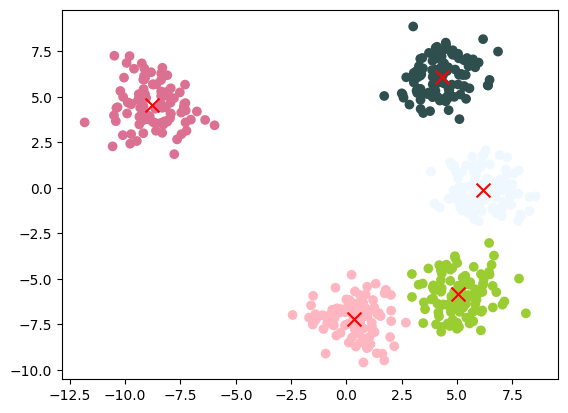

Iteration 20


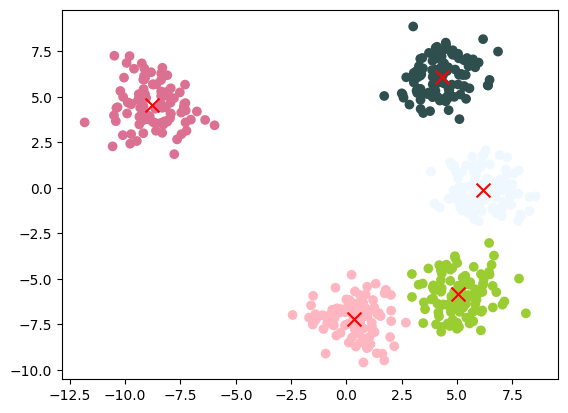

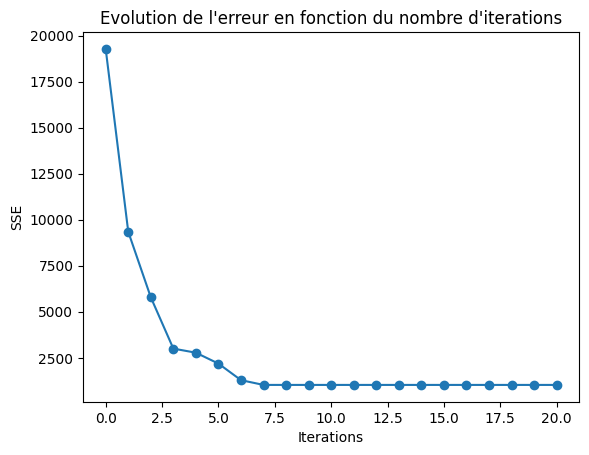

In [102]:
def kmeans(data, k, num_it ,centers=centers):
    centers_history = []
    sse_history = []

    # Initialisation des centres
    centers = initialize_centers(data, k)
    #centers = initialize_centers2(data, k) # pour kmeans ++

    

    for i in range(num_it):
        centers_history.append(np.array(centers))
        
        # Attribution des clusters
        clusters = compute_clusters(centers, data)
        
        # Calcul du SSE
        sse = sse_error(centers, data)
        sse_history.append(sse)
        
        # Mise à jour des centres
        new_centers = []
        for cluster_id in range(k):
            cluster_points = np.array([data[j] for j in range(len(data)) if clusters[j] == cluster_id])
            new_centers.append(np.mean(cluster_points, axis=0))

        centers = new_centers
        print(f"Iteration {i+1}")
        visualize_clustersDim(data, np.array(centers))
       

    # Dernière mise à jour des centres et SSE
    clusters = compute_clusters(centers, data)
    sse = sse_error(centers, data)
    centers_history.append(np.array(centers))
    sse_history.append(sse)

    # Affichage de l'évolution de l'erreur en fonction du nombre d'itérations
    plt.plot(range(num_it+1), sse_history, marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('SSE')
    plt.title('Evolution de l\'erreur en fonction du nombre d\'iterations')
    plt.show()

    # Retourne l'historique des centres et l'historique de SSE
    history = {'centers_history': centers_history, 'sse_history': sse_history}
    return history
h= kmeans(dataset,nb_of_clusters, 20)

In [ ]:
check_cluster_membership(h['centers_history'][0][0], h['centers_history'][0], compute_clusters(h['centers_history'][0], dataset))

False